In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.VERSION


'1.15.0'

In [3]:
#To import InstanceNormalization from keras-contrib
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-wk88gsr1
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-wk88gsr1
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=6bb7d5ed42890fb288988e1a112b4a2315c43a0471b830816ca2edeb7be11ea4
  Stored in directory: /tmp/pip-ephem-wheel-cache-27pu_za6/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [4]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

import sys
import numpy as np
import os

# Input shape
img_rows = 256
img_cols = 256
channels = 1
img_shape = (img_rows, img_cols, channels)

# Calculate output shape of D (PatchGAN)
patch = int(img_rows/2**4)
disc_patch = (patch, patch, 1)

# Loss weights
lambda_cycle = 10.0               # Cycle-consistency loss
lambda_id = 0.1 * lambda_cycle    # Identity loss

#Optimizer
optimizer = Adam(0.0002, 0.5)

def Generator():
  """Generator foloows U-Net Architecture"""

  # Image input
  inputs = Input(shape=img_shape)

  # Downsampling
  conv1 = Conv2D(filters=64, kernel_size=4, strides=2, padding='same')(inputs)
  conv1 = LeakyReLU(alpha=0.2)(conv1)
  conv1 = InstanceNormalization()(conv1)

  conv2 = Conv2D(filters=128, kernel_size=4, strides=2, padding='same')(conv1)
  conv2 = LeakyReLU(alpha=0.2)(conv2)
  conv2 = InstanceNormalization()(conv2)

  conv3 = Conv2D(filters=256, kernel_size=4, strides=2, padding='same')(conv2)
  conv3 = LeakyReLU(alpha=0.2)(conv3)
  conv3 = InstanceNormalization()(conv3)

  conv4 = Conv2D(filters=512, kernel_size=4, strides=2, padding='same')(conv3)
  conv4 = LeakyReLU(alpha=0.2)(conv4)
  conv4 = InstanceNormalization()(conv4)

  conv5 = Conv2D(filters=512, kernel_size=4, strides=2, padding='same')(conv4)
  conv5 = LeakyReLU(alpha=0.2)(conv5)
  conv5 = InstanceNormalization()(conv5)

  conv6 = Conv2D(filters=512, kernel_size=4, strides=2, padding='same')(conv5)
  conv6 = LeakyReLU(alpha=0.2)(conv6)
  conv6 = InstanceNormalization()(conv6)

  conv7 = Conv2D(filters=512, kernel_size=4, strides=2, padding='same')(conv6)
  conv7 = LeakyReLU(alpha=0.2)(conv7)
  conv7 = InstanceNormalization()(conv7)
  
  # Upsampling
  deconv1 = UpSampling2D(size=2)(conv7)
  deconv1 = Conv2D(filters=512, kernel_size=4, strides=1, padding='same', activation='relu')(deconv1)
  deconv1 = InstanceNormalization()(deconv1)
  deconv1 = Concatenate()([deconv1, conv6])

  deconv2 = UpSampling2D(size=2)(deconv1)
  deconv2 = Conv2D(filters=512, kernel_size=4, strides=1, padding='same', activation='relu')(deconv2)
  deconv2 = InstanceNormalization()(deconv2)
  deconv2 = Concatenate()([deconv2, conv5])

  deconv3 = UpSampling2D(size=2)(deconv2)
  deconv3 = Conv2D(filters=512, kernel_size=4, strides=1, padding='same', activation='relu')(deconv3)
  deconv3 = InstanceNormalization()(deconv3)
  deconv3 = Concatenate()([deconv3, conv4])

  deconv4 = UpSampling2D(size=2)(deconv3)
  deconv4 = Conv2D(filters=256, kernel_size=4, strides=1, padding='same', activation='relu')(deconv4)
  deconv4 = InstanceNormalization()(deconv4)
  deconv4 = Concatenate()([deconv4, conv3])

  deconv5 = UpSampling2D(size=2)(deconv4)
  deconv5 = Conv2D(filters=128, kernel_size=4, strides=1, padding='same', activation='relu')(deconv5)
  deconv5 = InstanceNormalization()(deconv5)
  deconv5 = Concatenate()([deconv5, conv2])

  deconv6 = UpSampling2D(size=2)(deconv5)
  deconv6 = Conv2D(filters=64, kernel_size=4, strides=1, padding='same', activation='relu')(deconv6)
  deconv6 = InstanceNormalization()(deconv6)
  deconv6 = Concatenate()([deconv6, conv1])

  deconv7 = UpSampling2D(size=2)(deconv6)
  outputs = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(deconv7)

  return Model(inputs = inputs, outputs = outputs)


def Discriminator():
  inputs = Input(shape=img_shape)

  outputs = Conv2D(filters=64, kernel_size=4, strides=2, padding='same')(inputs)
  outputs = LeakyReLU(alpha=0.2)(outputs)

  outputs = Conv2D(filters=128, kernel_size=4, strides=2, padding='same')(outputs)
  outputs = LeakyReLU(alpha=0.2)(outputs)
  outputs = InstanceNormalization()(outputs)

  outputs = Conv2D(filters=256, kernel_size=4, strides=2, padding='same')(outputs)
  outputs = LeakyReLU(alpha=0.2)(outputs)
  outputs = InstanceNormalization()(outputs)

  outputs = Conv2D(filters=512, kernel_size=4, strides=2, padding='same')(outputs)
  outputs = LeakyReLU(alpha=0.2)(outputs)
  outputs = InstanceNormalization()(outputs)
  
  outputs = Conv2D(1, kernel_size=4, strides=1, padding='same')(outputs)

  return Model(inputs = inputs, outputs = outputs)


# Build and compile the discriminators
D_A = Discriminator()
D_A.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
print(D_A.summary())

D_B = Discriminator()
D_B.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

#-------------------------
# Construct Computational
#   Graph of Generators
#-------------------------

# Build the generators
G_AB = Generator()
print(G_AB.summary())
G_BA = Generator()

# Input images from both domains
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# Translate images to the other domain
fake_B = G_AB(img_A)
fake_A = G_BA(img_B)
# Translate images back to original domain
reconstr_A = G_BA(fake_B)
reconstr_B = G_AB(fake_A)
# Identity mapping of images
img_A_id = G_BA(img_A)
img_B_id = G_AB(img_B)

# For the combined model we will only train the generators
D_A.trainable = False
D_B.trainable = False

# Discriminators determines validity of translated images
valid_A = D_A(fake_A)
valid_B = D_B(fake_B)

# Combined model trains generators to fool discriminators
combined = Model(inputs=[img_A, img_B], outputs=[valid_A, valid_B, reconstr_A, reconstr_B, img_A_id, img_B_id ])
combined.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'], loss_weights=[1, 1, lambda_cycle, lambda_cycle, lambda_id, lambda_id], optimizer=optimizer)



Using TensorFlow backend.



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1088      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 128)       2         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       524

Domain A Images : (2701, 256, 256, 1)
Domain B Images: (2701, 256, 256, 1)








/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


 Epoch: 1/100 | Batch: 1/2701 | D-loss: 26.637, D-acc: 9.08% | G-loss: 134.689 | adv: 58.245 | recon: 0.823 | id: 1.163 | time: 0:01:27.187070

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


 Epoch: 1/100 | Batch: 1000/2701 | D-loss: 0.276, D-acc: 33.59% | G-loss: 1.080 | adv: 0.297 | recon: 0.022 | id: 0.015 | time: 0:08:44.120978

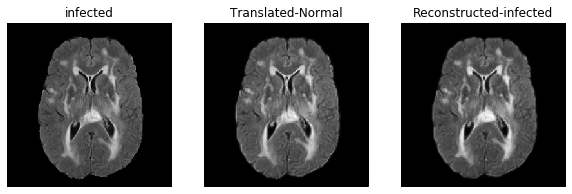

 Epoch: 1/100 | Batch: 2000/2701 | D-loss: 0.261, D-acc: 51.46% | G-loss: 1.139 | adv: 0.362 | recon: 0.018 | id: 0.033 | time: 0:15:52.017193

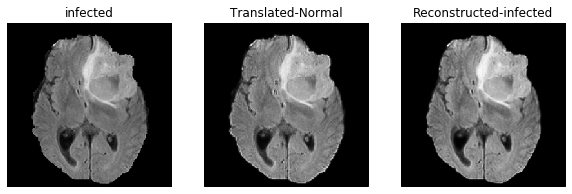

 Epoch: 2/100 | Batch: 1000/2701 | D-loss: 0.154, D-acc: 61.13% | G-loss: 1.469 | adv: 0.545 | recon: 0.016 | id: 0.037 | time: 0:28:20.351806

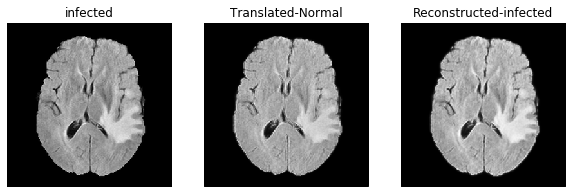

 Epoch: 2/100 | Batch: 2000/2701 | D-loss: 0.308, D-acc: 46.39% | G-loss: 1.372 | adv: 0.346 | recon: 0.029 | id: 0.062 | time: 0:35:28.615319

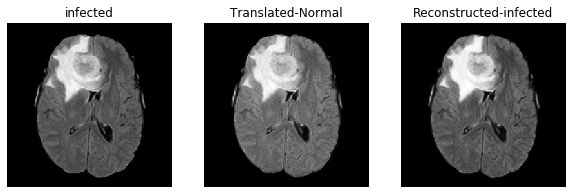

 Epoch: 3/100 | Batch: 1000/2701 | D-loss: 0.221, D-acc: 47.95% | G-loss: 0.898 | adv: 0.287 | recon: 0.013 | id: 0.038 | time: 0:47:41.368193

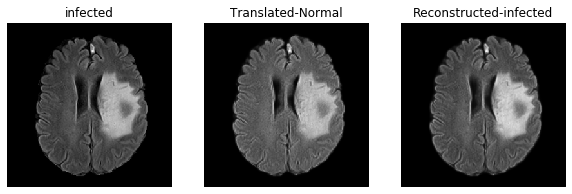

 Epoch: 3/100 | Batch: 2000/2701 | D-loss: 0.179, D-acc: 81.45% | G-loss: 1.029 | adv: 0.360 | recon: 0.012 | id: 0.033 | time: 0:54:48.332572

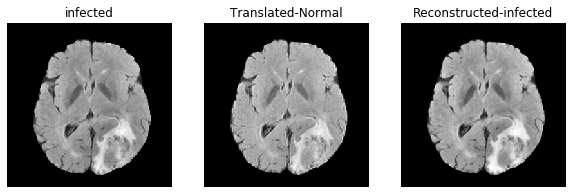

 Epoch: 4/100 | Batch: 1000/2701 | D-loss: 0.202, D-acc: 61.82% | G-loss: 1.211 | adv: 0.386 | recon: 0.019 | id: 0.032 | time: 1:07:00.346000

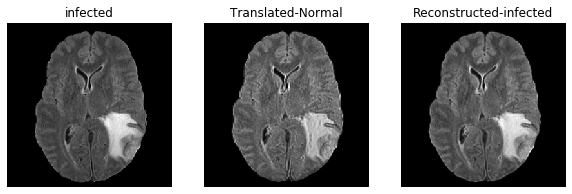

 Epoch: 4/100 | Batch: 2000/2701 | D-loss: 0.114, D-acc: 98.44% | G-loss: 1.598 | adv: 0.507 | recon: 0.025 | id: 0.041 | time: 1:14:09.011772

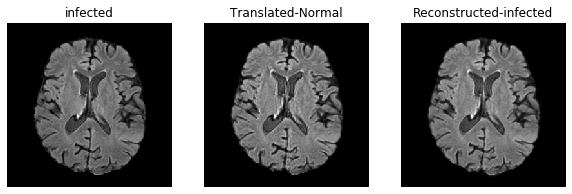

 Epoch: 5/100 | Batch: 1000/2701 | D-loss: 0.222, D-acc: 60.25% | G-loss: 1.312 | adv: 0.355 | recon: 0.027 | id: 0.023 | time: 1:26:20.142539

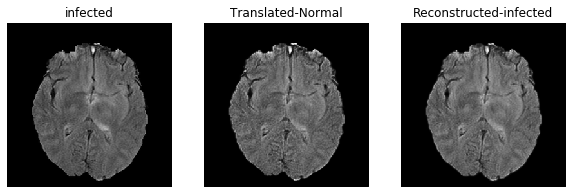

 Epoch: 5/100 | Batch: 2000/2701 | D-loss: 0.224, D-acc: 62.70% | G-loss: 1.161 | adv: 0.381 | recon: 0.016 | id: 0.038 | time: 1:33:28.143236

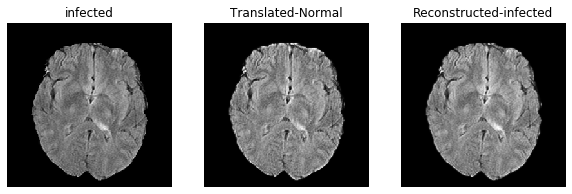

 Epoch: 6/100 | Batch: 1000/2701 | D-loss: 0.266, D-acc: 50.88% | G-loss: 1.363 | adv: 0.291 | recon: 0.036 | id: 0.037 | time: 1:45:36.404260

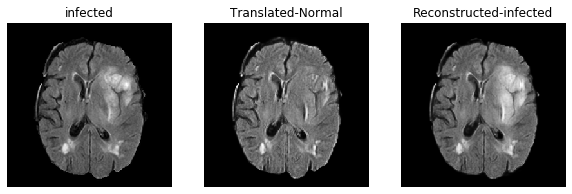

 Epoch: 6/100 | Batch: 2000/2701 | D-loss: 0.399, D-acc: 31.74% | G-loss: 1.193 | adv: 0.243 | recon: 0.031 | id: 0.050 | time: 1:52:46.875805

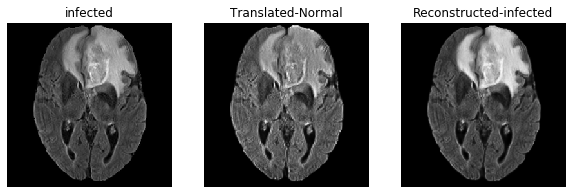

 Epoch: 7/100 | Batch: 1000/2701 | D-loss: 0.312, D-acc: 38.38% | G-loss: 0.823 | adv: 0.258 | recon: 0.012 | id: 0.034 | time: 2:04:56.349253

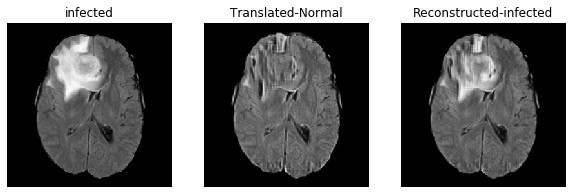

 Epoch: 7/100 | Batch: 2000/2701 | D-loss: 0.248, D-acc: 58.01% | G-loss: 1.189 | adv: 0.336 | recon: 0.022 | id: 0.043 | time: 2:12:05.611149

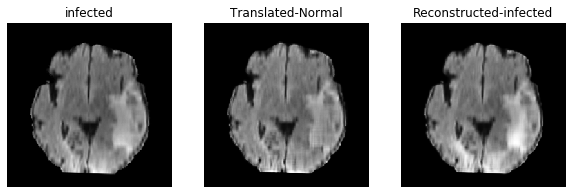

 Epoch: 8/100 | Batch: 1000/2701 | D-loss: 0.233, D-acc: 60.35% | G-loss: 1.006 | adv: 0.317 | recon: 0.017 | id: 0.015 | time: 2:24:17.396942

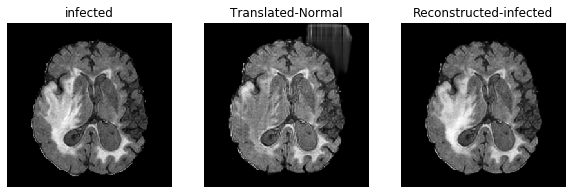

 Epoch: 8/100 | Batch: 2000/2701 | D-loss: 0.285, D-acc: 41.60% | G-loss: 0.907 | adv: 0.288 | recon: 0.013 | id: 0.037 | time: 2:31:25.302386

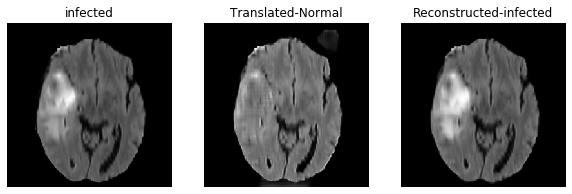

 Epoch: 9/100 | Batch: 1000/2701 | D-loss: 0.300, D-acc: 44.82% | G-loss: 0.964 | adv: 0.265 | recon: 0.019 | id: 0.014 | time: 2:43:33.547183

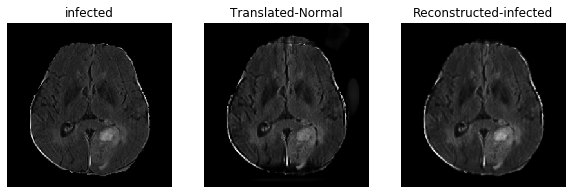

 Epoch: 9/100 | Batch: 2000/2701 | D-loss: 0.231, D-acc: 58.11% | G-loss: 1.090 | adv: 0.378 | recon: 0.014 | id: 0.020 | time: 2:50:42.272857

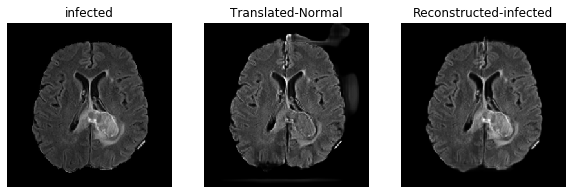

 Epoch: 10/100 | Batch: 1000/2701 | D-loss: 0.194, D-acc: 75.20% | G-loss: 1.138 | adv: 0.395 | recon: 0.015 | id: 0.014 | time: 3:02:52.656015

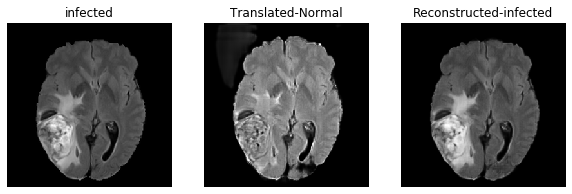

 Epoch: 10/100 | Batch: 2000/2701 | D-loss: 0.171, D-acc: 90.72% | G-loss: 1.177 | adv: 0.426 | recon: 0.013 | id: 0.018 | time: 3:10:02.723187

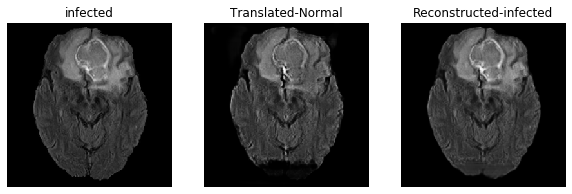

 Epoch: 11/100 | Batch: 1000/2701 | D-loss: 0.172, D-acc: 70.21% | G-loss: 1.396 | adv: 0.447 | recon: 0.022 | id: 0.026 | time: 3:22:13.588562

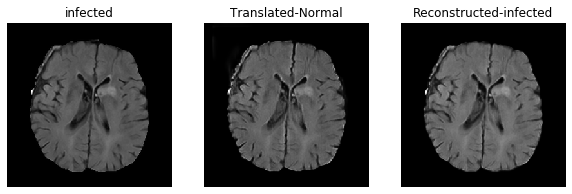

 Epoch: 11/100 | Batch: 2000/2701 | D-loss: 0.212, D-acc: 72.36% | G-loss: 1.238 | adv: 0.378 | recon: 0.021 | id: 0.019 | time: 3:29:21.345895

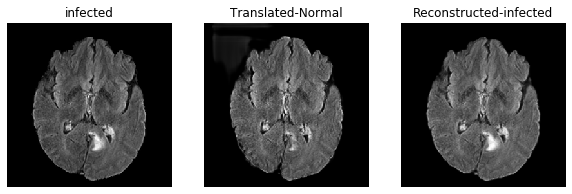

 Epoch: 12/100 | Batch: 1000/2701 | D-loss: 0.294, D-acc: 32.71% | G-loss: 1.066 | adv: 0.314 | recon: 0.019 | id: 0.011 | time: 3:41:30.776830

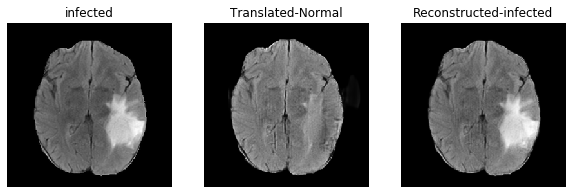

 Epoch: 12/100 | Batch: 1947/2701 | D-loss: 0.239, D-acc: 58.79% | G-loss: 1.339 | adv: 0.384 | recon: 0.027 | id: 0.015 | time: 3:48:16.899216

In [0]:
import datetime
import matplotlib.pyplot as plt
import sys
import random
import numpy as np
import os
from keras.preprocessing.image import load_img

os.chdir('/content/drive/My Drive/GitHub Repositories/Generative Models Papers with Implementation in Keras')
baseDir = './CycleGAN-Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks'

outputDir = os.path.join(baseDir, 'outputs', 'BRATS-infected2normal outputs')
if not os.path.exists(outputDir):
    os.makedirs(outputDir)
    print('Output Directory Created to save Results')
modelDir = os.path.join(baseDir, ' saved models', 'BRATS-infected2normal')
if not os.path.exists(modelDir):
    os.makedirs(modelDir)
    print('Model Directory Created to save Results')

trainDir = os.path.join(baseDir, 'datasets', 'BRATS_infected2normal', 'train')
validDir = os.path.join(baseDir, 'datasets', 'BRATS_infected2normal', 'valid')

infected_imgs = np.load(os.path.join(trainDir, 'infected_images.npy'), mmap_mode='r')
print('Domain A Images : {}'.format(infected_imgs.shape))
normal_imgs = np.load(os.path.join(trainDir, 'normal_images.npy'), mmap_mode='r')
print('Domain B Images: {}'.format(normal_imgs.shape))



start_time = datetime.datetime.now()
epochs = 100
batch_size = 1
batches=int(min(len(os.listdir(os.path.join(trainDir, 'infected'))), len(os.listdir(os.path.join(trainDir, 'normal'))))/batch_size)
save_interval = 1000

# Adversarial loss ground truths
valid = np.ones((batch_size,) + disc_patch)
fake = np.zeros((batch_size,) + disc_patch)




def save_imgs(epoch, batch):
  # pick random image from test data based on random indexes and reshape the image to tensor
  pickrandomInfectedImage = random.choice(os.listdir(os.path.join(trainDir, 'infected')))
  imgs_A = np.asarray(load_img(os.path.join(trainDir, 'infected', pickrandomInfectedImage), color_mode="grayscale"))
  imgs_A = imgs_A / 127.5 - 1
  imgs_A = imgs_A.reshape(-1, img_rows, img_cols, channels)

  # Translate images to opposite domain
  fake_B = G_AB.predict(imgs_A)
  
  # Translate back to original domain
  reconstr_A = G_BA.predict(fake_B)

  gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A])

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  titles = ['infected', 'Translated-Normal', 'Reconstructed-infected',]
  fig=plt.figure(1, figsize=(10, 10))
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(gen_imgs[i,..., 0], cmap='gray')
    plt.gca().set_title(titles[i])
    plt.axis('off')
  plt.show()
  fig.savefig(outputDir+'/image_at_epoch_{:04d}_batch_{:04d}.png'.format(epoch, batch))
  plt.close()

# Training 
for epoch in range(epochs):
  epoch+=1
  for batch in range(batches):
    batch+=1
    # ----------------------
    #  Train Discriminators
    # ----------------------

    # pick random image from training data based on random indexes and reshape the image to tensor
    random_index = random.randint(0, infected_imgs.shape[0]-1)
    imgs_A = infected_imgs[random_index]
    imgs_A = imgs_A.reshape(-1, img_rows, img_cols, channels)

    random_index = random.randint(0, normal_imgs.shape[0]-1)
    imgs_B = normal_imgs[random_index]
    imgs_B = imgs_B.reshape(-1, img_rows, img_cols, channels)


    # Translate images to opposite domain
    fake_B = G_AB.predict(imgs_A)
    fake_A = G_BA.predict(imgs_B)
    
    # Train the discriminators (original images = real / translated = Fake)
    dA_loss_real = D_A.train_on_batch(imgs_A, valid)
    dA_loss_fake = D_A.train_on_batch(fake_A, fake)
    dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

    dB_loss_real = D_B.train_on_batch(imgs_B, valid)
    dB_loss_fake = D_B.train_on_batch(fake_B, fake)
    dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

    # Total disciminator loss
    d_loss = 0.5 * np.add(dA_loss, dB_loss)
    
    # ------------------
    #  Train Generators
    # ------------------

    # Train the generators
    g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, valid, imgs_A, imgs_B, imgs_A, imgs_B])

    elapsed_time = datetime.datetime.now() - start_time
    sys.stdout.write('\r Epoch: {0}/{1} | Batch: {2}/{3} | D-loss: {4:.3f}, D-acc: {5:.2f}% | G-loss: {6:.3f} | adv: {7:.3f} | recon: {8:.3f} | id: {9:.3f} | time: {10}'.
                     format(epoch, epochs, batch, batches, d_loss[0], 100*d_loss[1], g_loss[0], np.mean(g_loss[1:3]), np.mean(g_loss[3:5]),
                            np.mean(g_loss[5:6]), elapsed_time))
    # After specific number of iterations say 200 in our case save results
    # If at save interval => save generated image samples
    if batch % save_interval == 0:
      save_imgs(epoch, batch)

  modelsaveDir = os.path.join(modelDir, 'Epoch_{}'.format(epoch))
  if not os.path.exists(modelsaveDir):
    os.makedirs(modelsaveDir)

  G_AB.save(os.path.join(modelsaveDir, 'G_infected2normal.h5'))
  G_BA.save(os.path.join(modelsaveDir, 'G_normal2infected.h5'))



In [0]:
import imageio
import os

os.chdir('/content/drive/My Drive/GitHub Repositories/Generative Models Papers with Implementation in Keras')
baseDir = './CycleGAN-Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks'

outputDir = os.path.join(baseDir, 'outputs', 'BRATS-infected2normal outputs')

images = []
for file_name in os.listdir(outputDir):
    if file_name.endswith('.png'):
        file_path = os.path.join(outputDir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave(os.path.join(baseDir, 'CycleGAN-BRATS-training-outputs.gif'), images, fps = 3)